In [3]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from sklearn import metrics

from src import scale_proportional
from src import getOriginFromCropped
from src import binary, otsu, watershed, region_growing
import src.description as description

In [4]:
# !wget -O dataset.zip "https://database.cric.com.br/api/v1/imagens/export?collection=1&images=1&classifications=0&segmentations=0" -nc
# !mkdir dataset
# !unzip -q dataset.zip -d dataset

In [5]:
# from src.data_handling import crop_dataset

# df = pd.read_csv('classifications.csv')
# crop_dataset(df)

In [6]:
df = pd.read_csv('./classifications.csv')
dir_path = './dataset'
test_img = '0a2a5a681410054941cc56f51eb8fbda.png'
df[df['image_filename'] == test_img]

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
5635,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5636,Negative for intraepithelial lesion,1012,875
5636,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5637,Negative for intraepithelial lesion,910,900
5637,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5638,Negative for intraepithelial lesion,1177,416
5638,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5639,Negative for intraepithelial lesion,1254,366
5639,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5640,LSIL,983,450


In [7]:
def crop_image_around_point(image, x, y, crop_size):
    # Calculate the top-left corner of the crop
    x_start = max(0, x - int(crop_size / 2))
    y_start = max(0, y - int(crop_size / 2))

    # Calculate the bottom-right corner of the crop
    x_end = min(image.shape[1], x + int(crop_size / 2))
    y_end = min(image.shape[0], y + int(crop_size / 2))

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    return cropped_image

In [8]:
def crop_with_pil(image, x, y, crop_size):
    lcrop = int(crop_size / 2)
    rcrop = int(crop_size - lcrop)
    width, height = image.size

    # Calculate the top-left corner of the crop
    x_start = max(0, x - lcrop)
    y_start = max(0, y - lcrop)

    # Calculate the bottom-right corner of the crop
    x_end = min(width, x + rcrop)
    y_end = min(height, y + rcrop)

    # Crop the image
    cropped_image = image.crop((x_start, y_start, x_end, y_end))

    return cropped_image

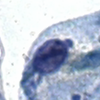

In [9]:
img_path = os.path.join(dir_path, test_img)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_img = crop_image_around_point(image, 1012, 875, 100)
img = Image.fromarray(cropped_img)
img

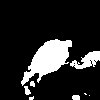

In [10]:
binary = binary(cropped_img, 127, invert=True)
Image.fromarray(binary)

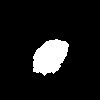

In [11]:
watershed_img = watershed(cropped_img)
Image.fromarray(watershed_img)

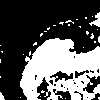

In [12]:
Image.fromarray(otsu(cropped_img, invert=True))

In [13]:
df = pd.read_csv('./main_data.csv')
df = df.drop(df.columns[[0]], axis=1)
df

,image,area,compactness,eccentricity,perimeter,label
0,./cropped_dataset/ASC-H/10.jpg,483,2.066071,0.511844,111.982755,ASC-H
1,./cropped_dataset/ASC-H/10000.jpg,673,2.907563,0.794802,156.811182,ASC-H
2,./cropped_dataset/ASC-H/10001.jpg,970,1.757551,0.497155,146.367531,ASC-H
3,./cropped_dataset/ASC-H/10002.jpg,731,1.570865,0.394551,120.124891,ASC-H
4,./cropped_dataset/ASC-H/10003.jpg,1063,1.394180,0.270889,136.468036,ASC-H
...,...,...,...,...,...,...
11529,./cropped_dataset/Negative for intraepithelial...,470,1.127330,0.478484,81.597979,Negative for intraepithelial lesion
11530,./cropped_dataset/Negative for intraepithelial...,327,1.050396,0.413155,65.698484,Negative for intraepithelial lesion
11531,./cropped_dataset/Negative for intraepithelial...,261,1.027138,0.314594,58.041630,Negative for intraepithelial lesion
11532,./cropped_dataset/Negative for intraepithelial...,835,1.574316,0.643762,128.526911,Negative for intraepithelial lesion


## Scatterplot (6)


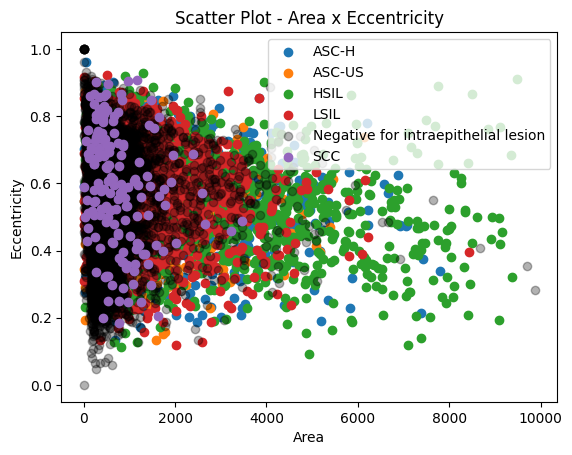

In [14]:
for label in np.unique(df['label']):
    if label == "Negative for intraepithelial lesion":
        plt.scatter(
            df[df['label'] == label]['area'],
            df[df['label'] == label]['eccentricity'],
            alpha=0.3,
            color='#000000',
        )
    else:
        plt.scatter(
            df[df['label'] == label]['area'],
            df[df['label'] == label]['eccentricity'],
            alpha=1,
        )

plt.title('Scatter Plot - Area x Eccentricity')
plt.xlabel('Area')
plt.ylabel('Eccentricity')
plt.legend(np.unique(df['label']))
plt.savefig('./model_data/scatter_all.png')
plt.show()

## Separacao dados (7)


In [15]:
X = df.drop(['label', 'image'], axis=1)  # Features
X['im_id'] = df['image'].apply(lambda p: p.split('/')[-1].split('.')[0])
y = df['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [16]:
np.unique(y_train, return_counts=True)[1] / np.unique(y_test, return_counts=True)[1]

array([4.        , 4.00826446, 3.9941349 , 4.        , 3.99926254,
       4.03125   ])

## Mahalanobis (8)


In [17]:
maha_X_train = X_train.drop(columns=['im_id'])
maha_X_test = X_test.drop(columns=['im_id'])

#### Negative x other


In [18]:
np.unique(y_train)

array(['ASC-H', 'ASC-US', 'HSIL', 'LSIL',
       'Negative for intraepithelial lesion', 'SCC'], dtype=object)

In [19]:
target_class = 'Negative for intraepithelial lesion'
mean_class_0 = maha_X_train[y_train == target_class].mean()
mean_class_1 = maha_X_train[y_train != target_class].mean()

covariance_class_0 = np.cov(maha_X_train[y_train == target_class], rowvar=False)
covariance_class_1 = np.cov(maha_X_train[y_train != target_class], rowvar=False)

inv_cov_class_0 = inv(covariance_class_0)
inv_cov_class_1 = inv(covariance_class_1)

In [20]:
test = [x.to_dict() for x in [mean_class_0, mean_class_1]]
with open("./model_data/mahalanobis/binary/class_means.json", "w") as f:
    json.dump(test, f)

with open("./model_data/mahalanobis/binary/labels.json", "w") as f:
    json.dump(["Negative", 'Positive'], f)

test = [(x.tolist()) for x in [inv_cov_class_0, inv_cov_class_1]]
with open("./model_data/mahalanobis/binary/inv_cov_matrices.json", "w") as f:
    json.dump(test, f)

In [21]:
with open("./model_data/mahalanobis/binary/class_means.json", "r") as f:
    class_means_bin = json.load(f)
    class_means_bin = [pd.Series(series_dict) for series_dict in class_means_bin]

with open("./model_data/mahalanobis/binary/labels.json", "r") as f:
    unique_classes_bin = json.load(f)

with open("./model_data/mahalanobis/binary/inv_cov_matrices.json", "r") as f:
    inv_cov_matrices_bin = json.load(f)

In [22]:
mahalanobis_dist_target = np.apply_along_axis(
    lambda x: mahalanobis(x, class_means_bin[0], inv_cov_matrices_bin[0]),
    axis=1,
    arr=maha_X_test,
)

mahalanobis_dist_other = np.apply_along_axis(
    lambda x: mahalanobis(x, class_means_bin[1], inv_cov_matrices_bin[1]),
    axis=1,
    arr=maha_X_test,
)

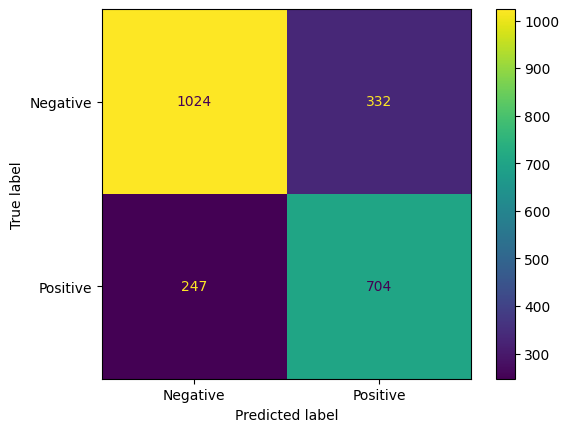

In [23]:
y_pred = np.where(mahalanobis_dist_target < mahalanobis_dist_other, 0, 1)
y_bin_test = np.where(y_test == target_class, 0, 1)

confusion_matrix = metrics.confusion_matrix(y_bin_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=unique_classes_bin
)
cm_display.plot()
plt.show()

In [24]:
print(metrics.classification_report(y_bin_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1356
           1       0.68      0.74      0.71       951

    accuracy                           0.75      2307
   macro avg       0.74      0.75      0.74      2307
weighted avg       0.75      0.75      0.75      2307



#### All classes


In [25]:
class_means = []
class_covariances = []
inv_cov_matrices = []

In [26]:
unique_classes = np.unique(y_train)
for class_label in unique_classes:
    class_data = maha_X_train[y_train == class_label]
    class_means.append(np.mean(class_data, axis=0))
    class_covariances.append(np.cov(class_data, rowvar=False))
    inv_cov_matrices.append(inv(class_covariances[-1]))

In [27]:
mahalanobis_dists = np.zeros((len(maha_X_test), len(unique_classes)))

In [28]:
unique_classes.tolist()

['ASC-H',
 'ASC-US',
 'HSIL',
 'LSIL',
 'Negative for intraepithelial lesion',
 'SCC']

In [29]:
test = [x.to_dict() for x in class_means]
with open("./model_data/mahalanobis/multiclass/class_means.json", "w") as f:
    json.dump(test, f)

with open("./model_data/mahalanobis/multiclass/labels.json", "w") as f:
    json.dump(unique_classes.tolist(), f)

test = [(x.tolist()) for x in inv_cov_matrices]
with open("./model_data/mahalanobis/multiclass/inv_cov_matrices.json", "w") as f:
    json.dump(test, f)

In [30]:
with open("./model_data/mahalanobis/multiclass/class_means.json", "r") as f:
    class_means = json.load(f)
    class_means = [pd.Series(series_dict) for series_dict in class_means]

with open("./model_data/mahalanobis/multiclass/labels.json", "r") as f:
    unique_classes = json.load(f)

with open("./model_data/mahalanobis/multiclass/inv_cov_matrices.json", "r") as f:
    inv_cov_matrices = json.load(f)

In [31]:
for i, class_label in enumerate(unique_classes):
    mahalanobis_dists[:, i] = np.apply_along_axis(
        lambda x: mahalanobis(x, class_means[i], inv_cov_matrices[i]),
        axis=1,
        arr=maha_X_test,
    )

In [32]:
y_pred = np.argmin(mahalanobis_dists, axis=1)
y_pred = list(map(lambda x: unique_classes[x], y_pred))

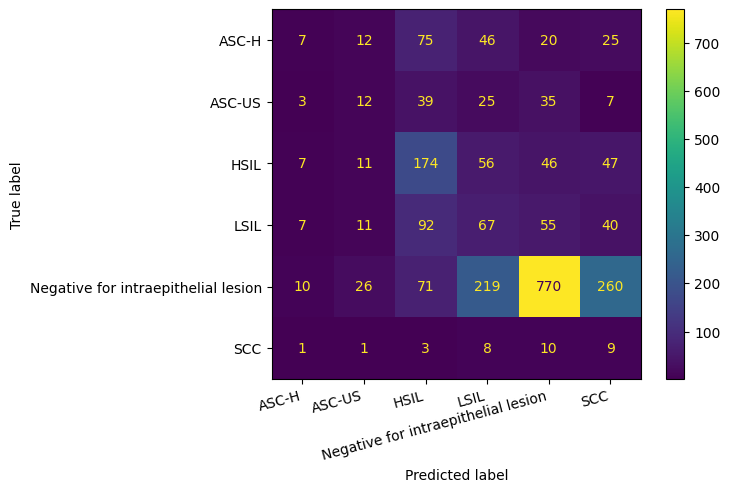

In [33]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=unique_classes
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')
plt.show()

In [34]:
print(metrics.classification_report(y_test, y_pred))

                                     precision    recall  f1-score   support

                              ASC-H       0.20      0.04      0.06       185
                             ASC-US       0.16      0.10      0.12       121
                               HSIL       0.38      0.51      0.44       341
                               LSIL       0.16      0.25      0.19       272
Negative for intraepithelial lesion       0.82      0.57      0.67      1356
                                SCC       0.02      0.28      0.04        32

                           accuracy                           0.45      2307
                          macro avg       0.29      0.29      0.26      2307
                       weighted avg       0.58      0.45      0.49      2307



In [35]:
data = (
    description.calculate_area(watershed_img),
    description.calculate_compactness(watershed_img),
    description.calculate_eccentricity(watershed_img),
    description.calculate_perimeter(watershed_img),
)

In [36]:
data

(926, 1.3365537276220156, 0.5641397645686083, 124.71067678928375)

In [37]:
test = np.zeros((1, len(unique_classes))).astype(object)
for i, class_label in enumerate(unique_classes):
    test[:, i] = {class_label: mahalanobis(data, class_means[i], inv_cov_matrices[i])}

In [38]:
for i, key in enumerate(test[0]):
    print(i, key)

0 {'ASC-H': 1.0095576945182008}
1 {'ASC-US': 0.9775457824304498}
2 {'HSIL': 1.0981514278125184}
3 {'LSIL': 0.9135418744389565}
4 {'Negative for intraepithelial lesion': 1.0333296220657857}
5 {'SCC': 1.1995378445642173}


## Rede Neural (9)


In [39]:
import numpy as np
import tensorflow as tf
import glob
from sklearn.preprocessing import LabelEncoder

In [61]:
from keras import Input
from keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Rescaling,
    BatchNormalization,
    Resizing
)
from tensorflow.keras.applications import mobilenet_v2, resnet50, efficientnet

In [41]:
def plot_results(history, show=True):
    hist_df = None
    if hasattr(history, 'history'):
        hist_df = pd.DataFrame(history.history)
    else:
        hist_df = pd.DataFrame(history)
    # hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df) + 1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    if show:
        plt.show()
    else:
        return fig, axs

In [42]:
def get_padding(image, pad_to):
    w, h = image.size
    h_padding = (pad_to - w) / 2
    v_padding = (pad_to - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding + 0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding + 0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding - 0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding - 0.5
    padding = [[int(t_pad), int(b_pad)], [int(l_pad), int(r_pad)], [0, 0]]
    return padding


def pad(img, pad_to=100):
    return tf.pad(
        tf.keras.utils.img_to_array(img, dtype=int),
        get_padding(img, pad_to),
        "CONSTANT",
        0,
    )

### Preparando Datasets

In [43]:
def get_images(root_dir='./cropped_dataset/*', include_ids=None):
    images = []
    labels = []

    for p in glob.glob(os.path.join(root_dir, '*.jpg')):
        label = p.split('\\')[-2]
        if label == 'Negative for intraepithelial lesion':
            label = 'Negative'
        id = p.split('\\')[-1].split('.')[0]
        path = p

        if include_ids is not None:
            if int(id) not in include_ids:
                continue

        im = Image.open(path)
        im = pad(im)
        images.append(im)
        labels.append(label)

    return (np.asarray(images), np.asarray(labels))

In [44]:
# gerando dados de validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)
X_train.shape, X_val.shape

((8304, 5), (923, 5))

In [45]:
X_train_nn, y_train_nn = get_images(include_ids=X_train['im_id'])
X_val_nn, y_val_nn = get_images(include_ids=X_val['im_id'])
X_test_nn, y_test_nn = get_images(include_ids=X_test['im_id'])

In [46]:
label_encoder = LabelEncoder()
y_train_all_classes = label_encoder.fit_transform(y_train_nn)
y_val_all_classes = label_encoder.transform(y_val_nn)
y_test_all_classes = label_encoder.transform(y_test_nn)

y_train_nn_ispos = np.where(y_train_nn != 'Negative', 1, 0)
y_val_nn_ispos = np.where(y_val_nn != 'Negative', 1, 0)
y_test_nn_ispos = np.where(y_test_nn != 'Negative', 1, 0)

In [47]:
np.save('.\\model_data\\nn\\label_encoder_classes.npy', label_encoder.classes_)

In [48]:
label_encoder_bin = LabelEncoder()
label_encoder_bin.fit(['Negative', 'Positive'])
np.save('.\\model_data\\nn\\label_encoder_bin.npy', label_encoder_bin.classes_)

In [49]:
train_ds_all = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_all_classes))
val_ds_all = tf.data.Dataset.from_tensor_slices((X_val_nn, y_val_all_classes))
test_ds_all = tf.data.Dataset.from_tensor_slices((X_test_nn, y_test_all_classes))

train_ds_pos = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_nn_ispos))
val_ds_pos = tf.data.Dataset.from_tensor_slices((X_val_nn, y_val_nn_ispos))
test_ds_pos = tf.data.Dataset.from_tensor_slices((X_test_nn, y_test_nn_ispos))

In [50]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 8196

train_data_all = train_ds_all.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data_all = val_ds_all.batch(BATCH_SIZE)
test_data_all = test_ds_all.batch(BATCH_SIZE)

train_data_pos = train_ds_pos.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data_pos = val_ds_pos.batch(BATCH_SIZE)
test_data_pos = test_ds_pos.batch(BATCH_SIZE)

### Modelo Baseline

#### Pos x Neg

In [49]:
pos_model = tf.keras.models.load_model(
    '.\\model_data\\nn\\baseline\\binary\\model.keras'
)
pos_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_13 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_39 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 47, 47, 32)        184

In [204]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
conv = Conv2D(64, (3, 3), activation='relu')(preprocess)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(32, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(16, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
global_pool = GlobalAveragePooling2D()(pool)
hidden1 = Dense(64, activation='relu')(global_pool)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)

pos_model = tf.keras.Model(inputs=input, outputs=output)
pos_model.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        184

In [205]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

pos_model.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [206]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_model.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

Epoch 1/32
260/260 [==============================] - 7s 22ms/step - loss: 0.5667 - accuracy: 0.7211 - val_loss: 0.6852 - val_accuracy: 0.5959
Epoch 2/32
260/260 [==============================] - 6s 21ms/step - loss: 0.4948 - accuracy: 0.7678 - val_loss: 0.5401 - val_accuracy: 0.7378
Epoch 3/32
260/260 [==============================] - 5s 21ms/step - loss: 0.4623 - accuracy: 0.7813 - val_loss: 0.4585 - val_accuracy: 0.7736
Epoch 4/32
260/260 [==============================] - 5s 21ms/step - loss: 0.4462 - accuracy: 0.7914 - val_loss: 0.4487 - val_accuracy: 0.7671
Epoch 5/32
260/260 [==============================] - 5s 21ms/step - loss: 0.4382 - accuracy: 0.7939 - val_loss: 0.4369 - val_accuracy: 0.7768
Epoch 6/32
260/260 [==============================] - 5s 21ms/step - loss: 0.4284 - accuracy: 0.8033 - val_loss: 0.4199 - val_accuracy: 0.7898
Epoch 7/32
260/260 [==============================] - 5s 21ms/step - loss: 0.4171 - accuracy: 0.8066 - val_loss: 0.4066 - val_accuracy: 0.8115

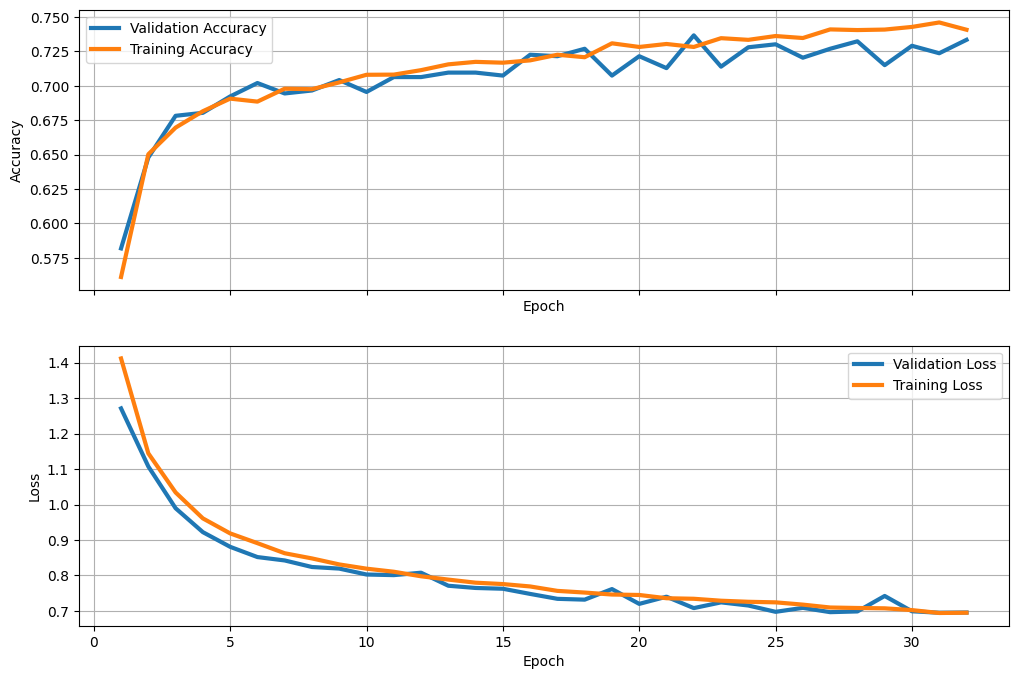

In [223]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\baseline\\binary\\graph.png')
plt.show()

73/73 [==============================] - 1s 12ms/step


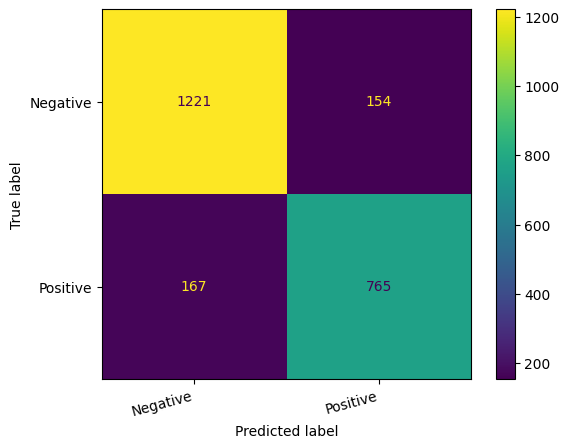

In [210]:
y_pred = np.where(pos_model.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\baseline\\binary\\confusion_matrix.png')
plt.show()

In [211]:
pos_model.evaluate(test_data_pos)

73/73 [==============================] - 1s 11ms/step - loss: 0.3291 - accuracy: 0.8609


[0.32912084460258484, 0.8608582615852356]

In [212]:
print(metrics.classification_report(y_test_nn_ispos, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1375
           1       0.83      0.82      0.83       932

    accuracy                           0.86      2307
   macro avg       0.86      0.85      0.86      2307
weighted avg       0.86      0.86      0.86      2307



In [213]:
pos_model.save('.\\model_data\\nn\\baseline\\binary\\model.keras')

#### All Classes

In [48]:
all_model = tf.keras.models.load_model(
    '.\\model_data\\nn\\baseline\\multiclass\\model.keras'
)
all_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_16 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_48 (Bat  (None, 98, 98, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 47, 47, 32)        184

In [214]:
input = Input(shape=(100, 100, 3))
preprocess = Rescaling(1.0 / 255.0)(input)
conv = Conv2D(64, (3, 3), activation='relu')(preprocess)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(32, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
conv = Conv2D(16, (3, 3), activation='relu')(pool)
bn = BatchNormalization()(conv)
pool = MaxPooling2D((2, 2))(bn)
global_pool = GlobalAveragePooling2D()(pool)
hidden1 = Dense(64, activation='relu')(global_pool)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(6, activation='softmax')(hidden2)

all_model = tf.keras.Model(inputs=input, outputs=output)
all_model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_11 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization_3 (Batc  (None, 98, 98, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        184

In [215]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

all_model.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [216]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_model.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

Epoch 1/32
260/260 [==============================] - 7s 23ms/step - loss: 1.4119 - accuracy: 0.5610 - val_loss: 1.2711 - val_accuracy: 0.5818
Epoch 2/32
260/260 [==============================] - 6s 21ms/step - loss: 1.1443 - accuracy: 0.6502 - val_loss: 1.1073 - val_accuracy: 0.6479
Epoch 3/32
260/260 [==============================] - 6s 21ms/step - loss: 1.0341 - accuracy: 0.6696 - val_loss: 0.9895 - val_accuracy: 0.6782
Epoch 4/32
260/260 [==============================] - 6s 23ms/step - loss: 0.9609 - accuracy: 0.6816 - val_loss: 0.9221 - val_accuracy: 0.6804
Epoch 5/32
260/260 [==============================] - 6s 22ms/step - loss: 0.9186 - accuracy: 0.6907 - val_loss: 0.8807 - val_accuracy: 0.6923
Epoch 6/32
260/260 [==============================] - 6s 22ms/step - loss: 0.8910 - accuracy: 0.6885 - val_loss: 0.8518 - val_accuracy: 0.7021
Epoch 7/32
260/260 [==============================] - 6s 22ms/step - loss: 0.8626 - accuracy: 0.6979 - val_loss: 0.8423 - val_accuracy: 0.6945

FileNotFoundError: [Errno 2] No such file or directory: '.\\model_data\\nn\\baseline\\all_classes\\graph.png'

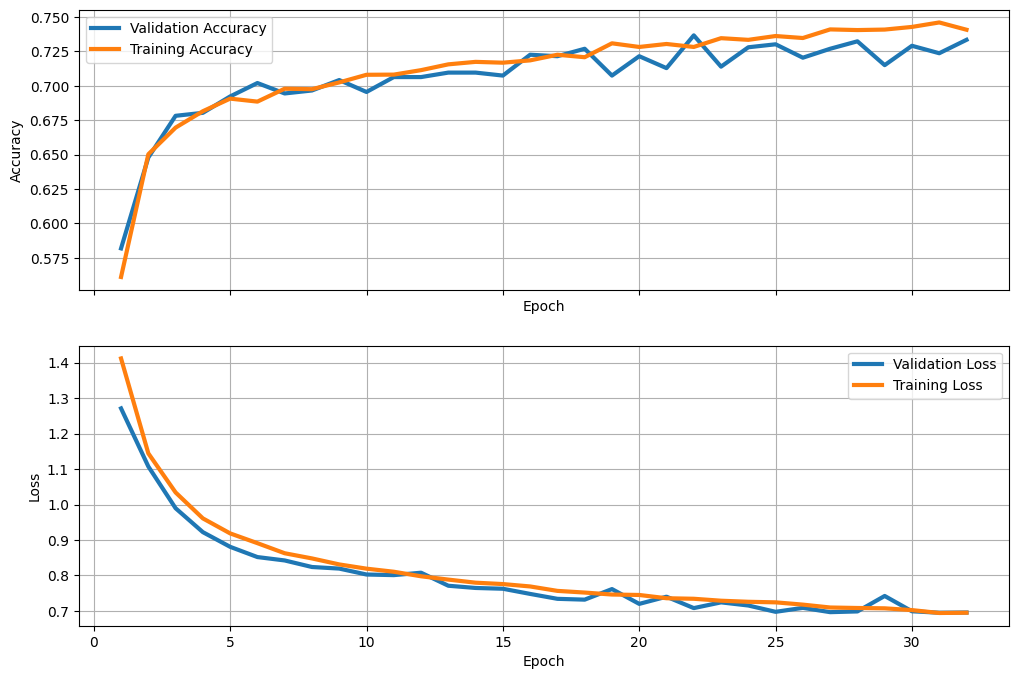

In [218]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\baseline\\all_classes\\graph.png')
plt.show()

73/73 [==============================] - 1s 12ms/step


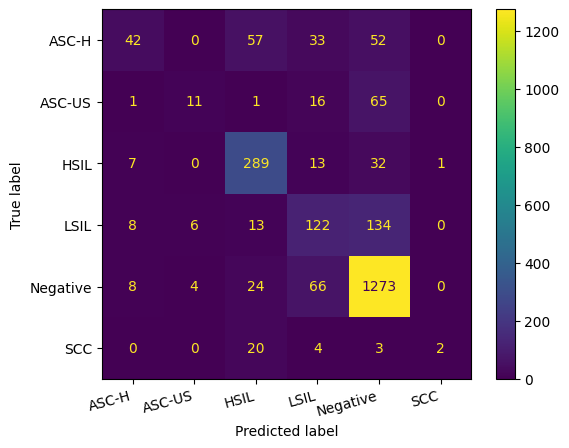

In [219]:
y_pred = np.argmax(all_model.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)


cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\baseline\\multiclass\\confusion_matrix.png')
plt.show()

In [220]:
all_model.evaluate(test_data_all)

 1/73 [..............................] - ETA: 2s - loss: 1.5065 - accuracy: 0.3438

73/73 [==============================] - 1s 11ms/step - loss: 0.6739 - accuracy: 0.7538


[0.6739045977592468, 0.7537928223609924]

In [221]:
print(metrics.classification_report(y_test_all_classes, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.23      0.34       184
           1       0.52      0.12      0.19        94
           2       0.72      0.85      0.77       342
           3       0.48      0.43      0.45       283
           4       0.82      0.93      0.87      1375
           5       0.67      0.07      0.12        29

    accuracy                           0.75      2307
   macro avg       0.64      0.44      0.46      2307
weighted avg       0.73      0.75      0.72      2307



In [222]:
all_model.save('.\\model_data\\nn\\baseline\\multiclass\\model.keras')

### Modelo Resnet

#### Pos x Neg

In [65]:
pos_resnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\resnet\\binary\\model.keras'
)
pos_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']          

In [74]:
input = Input(shape=(100, 100, 3))
preprocess = resnet50.preprocess_input(input)
resnet = resnet50.ResNet50(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(resnet.output)
output = Dense(1, activation='sigmoid')(global_pool)

pos_resnet = tf.keras.Model(inputs=input, outputs=output)
pos_resnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 100, 100, 3)  0          ['input_6[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 100, 100, 3)  0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                          

In [75]:
# number of layers that will be trained
trainable_layers = len(pos_resnet.layers)/5

for i, l in enumerate(pos_resnet.layers):
    if len(pos_resnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

In [76]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

pos_resnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [77]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_resnet.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 19s 55ms/step - loss: 0.6509 - accuracy: 0.6448 - val_loss: 0.5622 - val_accuracy: 0.7161
Epoch 2/32
260/260 [==============================] - 12s 44ms/step - loss: 0.5152 - accuracy: 0.7519 - val_loss: 0.4952 - val_accuracy: 0.7725
Epoch 3/32
260/260 [==============================] - 12s 45ms/step - loss: 0.4522 - accuracy: 0.7969 - val_loss: 0.4574 - val_accuracy: 0.7996
Epoch 4/32
260/260 [==============================] - 12s 45ms/step - loss: 0.4110 - accuracy: 0.8152 - val_loss: 0.4323 - val_accuracy: 0.8212
Epoch 5/32
260/260 [==============================] - 12s 45ms/step - loss: 0.3802 - accuracy: 0.8326 - val_loss: 0.4134 - val_accuracy: 0.8321
Epoch 6/32
260/260 [==============================] - 12s 45ms/step - loss: 0.3545 - accuracy: 0.8537 - val_loss: 0.3972 - val_accuracy: 0.8375
Epoch 7/32
260/260 [==============================] - 12s 45ms/step - loss: 0.3351 - accuracy: 0.8591 - val_loss: 0.3844 - val_accuracy: 0.8418
Epo

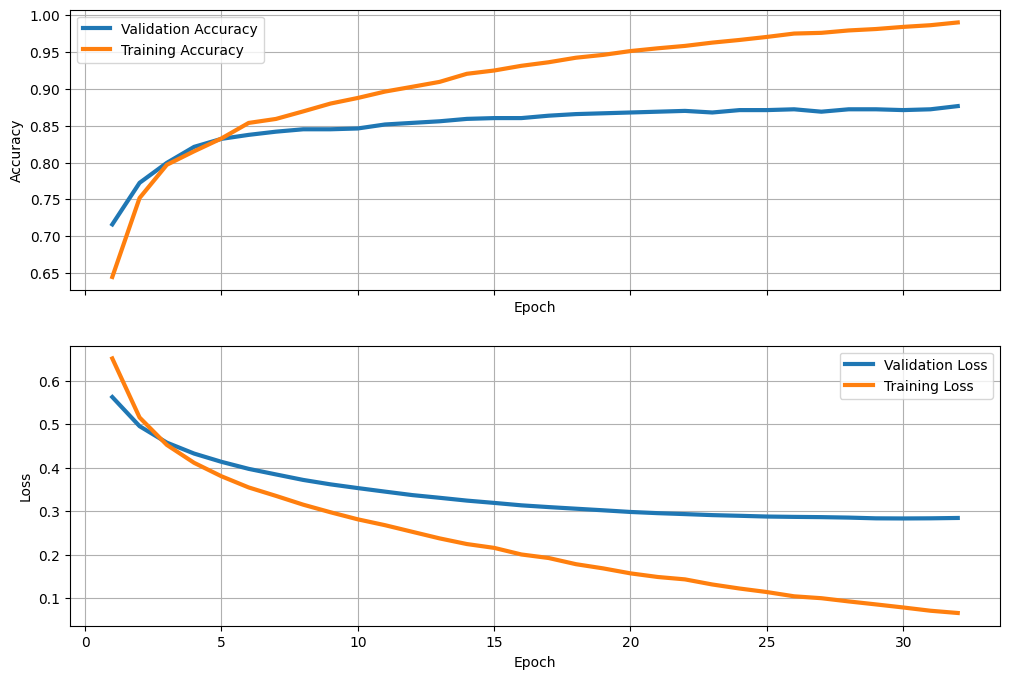

In [79]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\resnet\\binary\\graph.png')
plt.show()

73/73 [==============================] - 4s 47ms/step


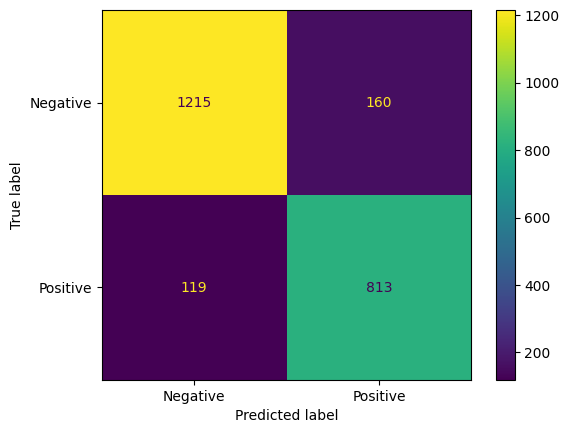

In [80]:
y_pred = np.where(pos_resnet.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
# plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\resnet\\binary\\confusion_matrix.png')
plt.show()

In [81]:
pos_resnet.evaluate(test_data_pos)

73/73 [==============================] - 4s 57ms/step - loss: 0.3117 - accuracy: 0.8791


[0.31171631813049316, 0.8790637254714966]

In [82]:
print(metrics.classification_report(y_test_nn_ispos, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1375
           1       0.84      0.87      0.85       932

    accuracy                           0.88      2307
   macro avg       0.87      0.88      0.88      2307
weighted avg       0.88      0.88      0.88      2307



In [83]:
pos_resnet.save('.\\model_data\\nn\\resnet\\binary\\model.keras')

#### All Classes

In [69]:
all_resnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\resnet\\multiclass\\model.keras'
)
all_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']          

In [100]:
input = Input(shape=(100, 100, 3))
preprocess = resnet50.preprocess_input(input)
resnet = resnet50.ResNet50(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(resnet.output)
output = Dense(6, activation='softmax')(global_pool)

all_resnet = tf.keras.Model(inputs=input, outputs=output)
all_resnet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 100, 100, 3)  0          ['input_10[0][0]']               
 icingOpLambda)                                                                                   
                                                                                                  
 tf.nn.bias_add_4 (TFOpLambda)  (None, 100, 100, 3)  0           ['tf.__operators__.getitem_4[0][0
                                                                 ]']                        

In [101]:
# number of layers that will be trained
trainable_layers = len(all_resnet.layers) / 6

for i, l in enumerate(all_resnet.layers):
    if len(all_resnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

all_resnet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 100, 100, 3)  0          ['input_10[0][0]']               
 icingOpLambda)                                                                                   
                                                                                                  
 tf.nn.bias_add_4 (TFOpLambda)  (None, 100, 100, 3)  0           ['tf.__operators__.getitem_4[0][0
                                                                 ]']                        

                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['tf.nn.bias_add_4[0][0]']       
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']             
                                                                                                  
 conv1_relu (Activation)        (None, 50, 50, 64)   0           ['conv1_bn[0][0]']               
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 52, 52, 64)   0           ['conv1_relu[0][0]']             
          

In [102]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)

all_resnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [103]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_resnet.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 22s 71ms/step - loss: 1.0072 - accuracy: 0.6412 - val_loss: 0.7464 - val_accuracy: 0.7183
Epoch 2/32
260/260 [==============================] - 12s 48ms/step - loss: 0.4663 - accuracy: 0.8432 - val_loss: 0.6598 - val_accuracy: 0.7616
Epoch 3/32
260/260 [==============================] - 13s 48ms/step - loss: 0.2616 - accuracy: 0.9280 - val_loss: 0.6497 - val_accuracy: 0.7703
Epoch 4/32
260/260 [==============================] - 13s 48ms/step - loss: 0.1368 - accuracy: 0.9778 - val_loss: 0.6404 - val_accuracy: 0.7920
Epoch 5/32
260/260 [==============================] - 12s 46ms/step - loss: 0.0741 - accuracy: 0.9934 - val_loss: 0.6471 - val_accuracy: 0.7963
Epoch 6/32
260/260 [==============================] - 12s 47ms/step - loss: 0.0399 - accuracy: 0.9984 - val_loss: 0.6484 - val_accuracy: 0.8028
Epoch 7/32
260/260 [==============================] - 12s 46ms/step - loss: 0.0249 - accuracy: 0.9995 - val_loss: 0.6692 - val_accuracy: 0.7974
Epo

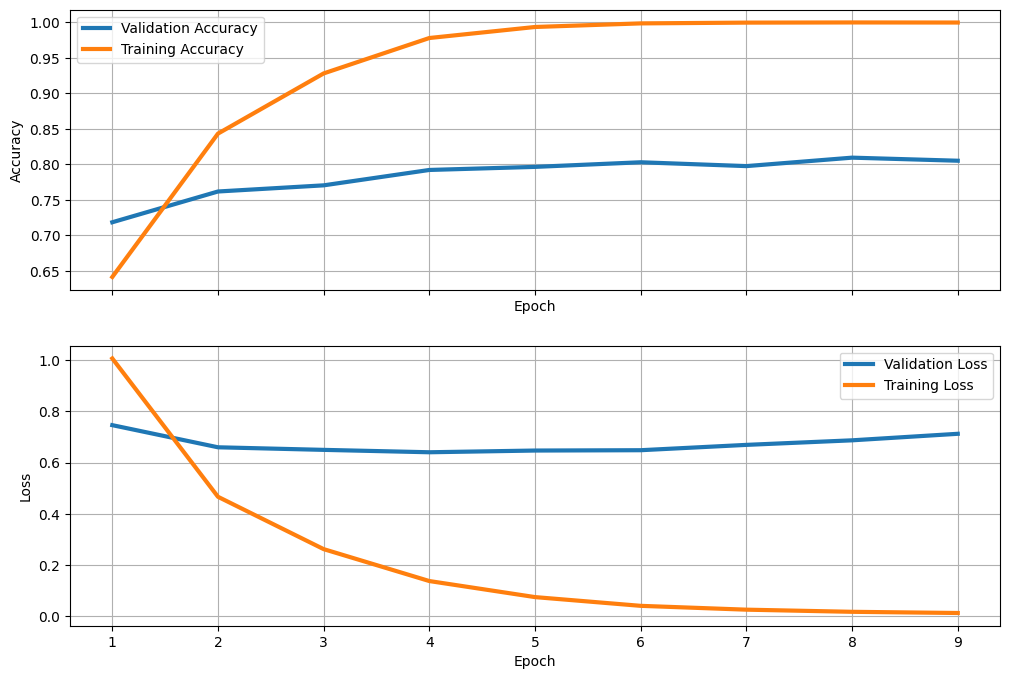

In [104]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\resnet\\multiclass\\graph.png')
plt.show()

73/73 [==============================] - 6s 70ms/step


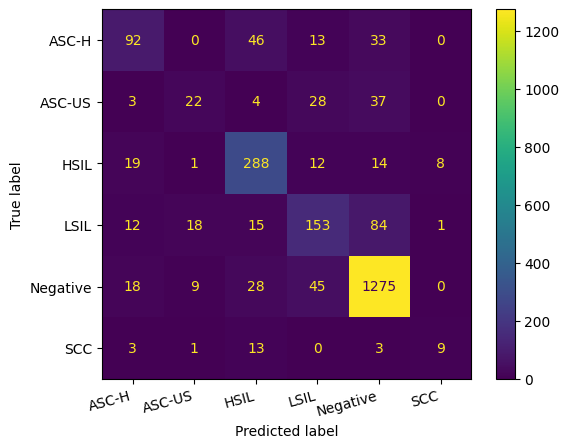

In [105]:
y_pred = np.argmax(all_resnet.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\resnet\\multiclass\\confusion_matrix.png')
plt.show()

In [106]:
all_resnet.evaluate(test_data_all)

 1/73 [..............................] - ETA: 4s - loss: 1.0223 - accuracy: 0.5625

73/73 [==============================] - 3s 38ms/step - loss: 0.6045 - accuracy: 0.7971


[0.6045006513595581, 0.7971391677856445]

In [107]:
print(metrics.classification_report(y_test_all_classes, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.50      0.56       184
           1       0.43      0.23      0.30        94
           2       0.73      0.84      0.78       342
           3       0.61      0.54      0.57       283
           4       0.88      0.93      0.90      1375
           5       0.50      0.31      0.38        29

    accuracy                           0.80      2307
   macro avg       0.63      0.56      0.58      2307
weighted avg       0.78      0.80      0.79      2307



In [108]:
all_resnet.save('.\\model_data\\nn\\resnet\\multiclass\\model.keras')

### Modelo EfficientNet

#### Pos x Neg

In [229]:
pos_effnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\efficientNet\\binary\\model.keras'
)
pos_effnet.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_36 (Rescaling)       (None, 100, 100, 3)  0           ['input_26[0][0]']               
                                                                                                  
 rescaling_37 (Rescaling)       (None, 100, 100, 3)  0           ['rescaling_36[0][0]']           
                                                                                                  
 normalization_12 (Normalizatio  (None, 100, 100, 3)  7          ['rescaling_37[0][0]']    

In [113]:
input = Input(shape=(100, 100, 3))
preprocess = efficientnet.preprocess_input(input)
effnet = efficientnet.EfficientNetB3(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(effnet.output)
output = Dense(1, activation='sigmoid')(global_pool)

pos_effnet = tf.keras.Model(inputs=input, outputs=output)
pos_effnet.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 100, 100, 3)  0           ['input_12[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 100, 100, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                           

In [114]:
# number of layers that will be trained
trainable_layers = len(pos_effnet.layers)/5

for i, l in enumerate(pos_effnet.layers):
    if len(pos_effnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

pos_effnet.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 100, 100, 3)  0           ['input_12[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 100, 100, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                           

In [115]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

pos_effnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [116]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_effnet.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 37s 107ms/step - loss: 0.5921 - accuracy: 0.6799 - val_loss: 0.5193 - val_accuracy: 0.7508
Epoch 2/32
260/260 [==============================] - 21s 80ms/step - loss: 0.4595 - accuracy: 0.7934 - val_loss: 0.4524 - val_accuracy: 0.7855
Epoch 3/32
260/260 [==============================] - 21s 81ms/step - loss: 0.4050 - accuracy: 0.8198 - val_loss: 0.4193 - val_accuracy: 0.7985
Epoch 4/32
260/260 [==============================] - 21s 80ms/step - loss: 0.3766 - accuracy: 0.8287 - val_loss: 0.4008 - val_accuracy: 0.8180
Epoch 5/32
260/260 [==============================] - 19s 72ms/step - loss: 0.3444 - accuracy: 0.8537 - val_loss: 0.3856 - val_accuracy: 0.8277
Epoch 6/32
260/260 [==============================] - 13s 48ms/step - loss: 0.3237 - accuracy: 0.8614 - val_loss: 0.3742 - val_accuracy: 0.8332
Epoch 7/32
260/260 [==============================] - 13s 50ms/step - loss: 0.3076 - accuracy: 0.8667 - val_loss: 0.3649 - val_accuracy: 0.8407
Ep

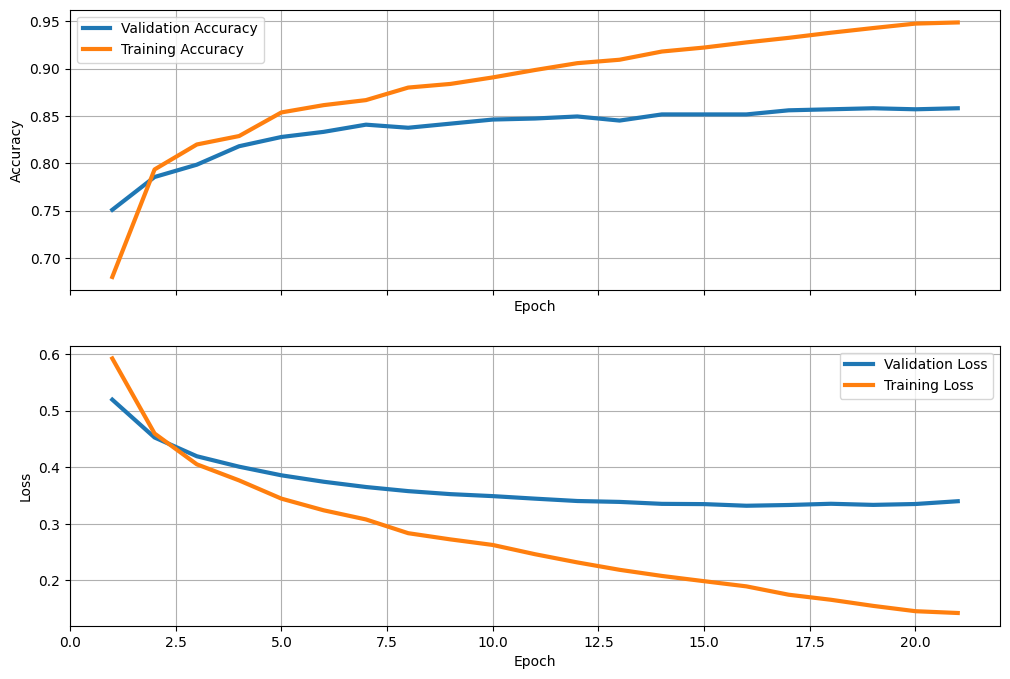

In [117]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\efficientNet\\binary\\graph.png')
plt.show()

73/73 [==============================] - 10s 89ms/step


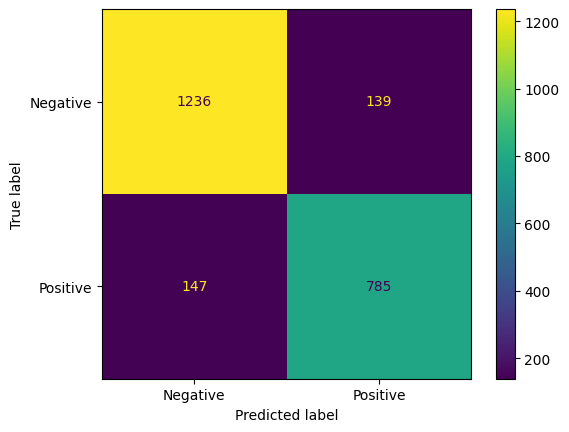

In [118]:
y_pred = np.where(pos_effnet.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
# plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\efficientNet\\binary\\confusion_matrix.png')
plt.show()

In [119]:
pos_effnet.evaluate(test_data_pos)

73/73 [==============================] - 3s 39ms/step - loss: 0.2952 - accuracy: 0.8760


[0.2951923906803131, 0.8760294914245605]

In [120]:
print(metrics.classification_report(y_test_nn_ispos, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1375
           1       0.85      0.84      0.85       932

    accuracy                           0.88      2307
   macro avg       0.87      0.87      0.87      2307
weighted avg       0.88      0.88      0.88      2307



In [121]:
pos_effnet.save('.\\model_data\\nn\\efficientNet\\binary\\model.keras')

#### All Classes

In [122]:
all_effnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\efficientNet\\multiclass\\model.keras'
)
all_effnet.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_60 (Rescaling)       (None, 100, 100, 3)  0           ['input_43[0][0]']               
                                                                                                  
 rescaling_61 (Rescaling)       (None, 100, 100, 3)  0           ['rescaling_60[0][0]']           
                                                                                                  
 normalization_19 (Normalizatio  (None, 100, 100, 3)  7          ['rescaling_61[0][0]']    

In [131]:
input = Input(shape=(100, 100, 3))
preprocess = efficientnet.preprocess_input(input)
effnet = efficientnet.EfficientNetB3(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(effnet.output)
output = Dense(6, activation='softmax')(global_pool)

all_effnet = tf.keras.Model(inputs=input, outputs=output)
all_effnet.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 100, 100, 3)  0           ['input_15[0][0]']               
                                                                                                  
 normalization_4 (Normalization  (None, 100, 100, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                           

In [132]:
# number of layers that will be trained
trainable_layers = len(all_effnet.layers) / 6

for i, l in enumerate(all_effnet.layers):
    if len(all_effnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

all_effnet.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 100, 100, 3)  0           ['input_15[0][0]']               
                                                                                                  
 normalization_4 (Normalization  (None, 100, 100, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                           

In [133]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

all_effnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [134]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_effnet.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 29s 73ms/step - loss: 1.0634 - accuracy: 0.6263 - val_loss: 0.8710 - val_accuracy: 0.6739
Epoch 2/32
260/260 [==============================] - 20s 76ms/step - loss: 0.7094 - accuracy: 0.7511 - val_loss: 0.7594 - val_accuracy: 0.7248
Epoch 3/32
260/260 [==============================] - 20s 76ms/step - loss: 0.5745 - accuracy: 0.7984 - val_loss: 0.7079 - val_accuracy: 0.7465
Epoch 4/32
260/260 [==============================] - 20s 77ms/step - loss: 0.4726 - accuracy: 0.8360 - val_loss: 0.6758 - val_accuracy: 0.7541
Epoch 5/32
260/260 [==============================] - 20s 76ms/step - loss: 0.3910 - accuracy: 0.8658 - val_loss: 0.6633 - val_accuracy: 0.7660
Epoch 6/32
260/260 [==============================] - 19s 75ms/step - loss: 0.3283 - accuracy: 0.8933 - val_loss: 0.6683 - val_accuracy: 0.7671
Epoch 7/32
260/260 [==============================] - 19s 75ms/step - loss: 0.2675 - accuracy: 0.9134 - val_loss: 0.6721 - val_accuracy: 0.7692
Epo

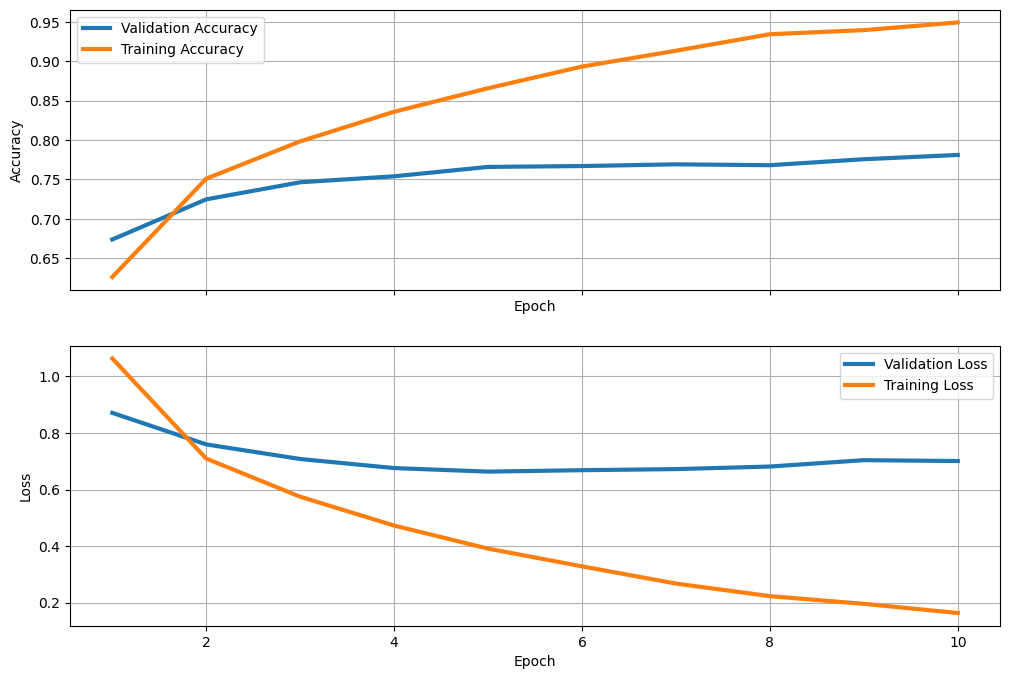

In [135]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\efficientNet\\multiclass\\graph.png')
plt.show()

73/73 [==============================] - 5s 39ms/step


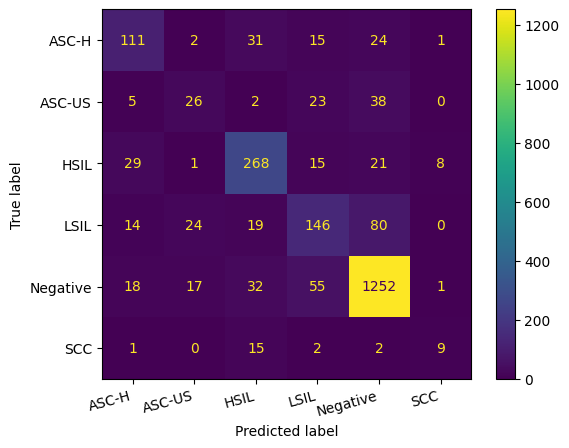

In [136]:
y_pred = np.argmax(all_effnet.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\efficientNet\\multiclass\\confusion_matrix.png')
plt.show()

In [137]:
all_effnet.evaluate(test_data_all)

73/73 [==============================] - 5s 73ms/step - loss: 0.5971 - accuracy: 0.7854


[0.597055971622467, 0.7854356169700623]

In [138]:
print(metrics.classification_report(y_test_all_classes, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       184
           1       0.37      0.28      0.32        94
           2       0.73      0.78      0.76       342
           3       0.57      0.52      0.54       283
           4       0.88      0.91      0.90      1375
           5       0.47      0.31      0.38        29

    accuracy                           0.79      2307
   macro avg       0.61      0.57      0.58      2307
weighted avg       0.78      0.79      0.78      2307



In [139]:
all_effnet.save('.\\model_data\\nn\\efficientNet\\multiclass\\model.keras')

### Modelo MobileNet

#### Pos x Neg

In [ ]:
pos_mobnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\mobileNet\\binary\\model.keras'
)
pos_mobnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']          

In [150]:
input = Input(shape=(100, 100, 3))
preprocess = mobilenet_v2.preprocess_input(input)
mobnet = mobilenet_v2.MobileNetV2(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(mobnet.output)
output = Dense(1, activation='sigmoid')(global_pool)

pos_mobnet = tf.keras.Model(inputs=input, outputs=output)
pos_mobnet.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_10 (TFOpLambda  (None, 100, 100, 3)  0          ['input_18[0][0]']               
 )                                                                                                
                                                                                                  
 tf.math.subtract_5 (TFOpLambda  (None, 100, 100, 3)  0          ['tf.math.truediv_10[0][0]']     
 )                                                                                         

In [151]:
# number of layers that will be trained
trainable_layers = len(pos_mobnet.layers)/5

for i, l in enumerate(pos_mobnet.layers):
    if len(pos_mobnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

pos_mobnet.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_10 (TFOpLambda  (None, 100, 100, 3)  0          ['input_18[0][0]']               
 )                                                                                                
                                                                                                  
 tf.math.subtract_5 (TFOpLambda  (None, 100, 100, 3)  0          ['tf.math.truediv_10[0][0]']     
 )                                                                                         

 expanded_conv_depthwise_BN (Ba  (None, 50, 50, 32)  128         ['expanded_conv_depthwise[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 expanded_conv_depthwise_relu (  (None, 50, 50, 32)  0           ['expanded_conv_depthwise_BN[0][0
 ReLU)                                                           ]']                              
                                                                                                  
 expanded_conv_project (Conv2D)  (None, 50, 50, 16)  512         ['expanded_conv_depthwise_relu[0]
                                                                 [0]']                            
                                                                                                  
 expanded_conv_project_BN (Batc  (None, 50, 50, 16)  64          ['expanded_conv_project[0][0]']  
 hNormaliz

In [152]:
loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

pos_mobnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [153]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = pos_mobnet.fit(
    train_data_pos, epochs=epochs, validation_data=val_data_pos, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 18s 45ms/step - loss: 0.5279 - accuracy: 0.7282 - val_loss: 0.5294 - val_accuracy: 0.7508
Epoch 2/32
260/260 [==============================] - 10s 37ms/step - loss: 0.3868 - accuracy: 0.8266 - val_loss: 0.4257 - val_accuracy: 0.8104
Epoch 3/32
260/260 [==============================] - 10s 37ms/step - loss: 0.3326 - accuracy: 0.8540 - val_loss: 0.3786 - val_accuracy: 0.8342
Epoch 4/32
260/260 [==============================] - 10s 37ms/step - loss: 0.2926 - accuracy: 0.8781 - val_loss: 0.3564 - val_accuracy: 0.8429
Epoch 5/32
260/260 [==============================] - 10s 37ms/step - loss: 0.2593 - accuracy: 0.8917 - val_loss: 0.3381 - val_accuracy: 0.8483
Epoch 6/32
260/260 [==============================] - 10s 37ms/step - loss: 0.2354 - accuracy: 0.9058 - val_loss: 0.3304 - val_accuracy: 0.8516
Epoch 7/32
260/260 [==============================] - 10s 37ms/step - loss: 0.2077 - accuracy: 0.9209 - val_loss: 0.3287 - val_accuracy: 0.8516
Epo

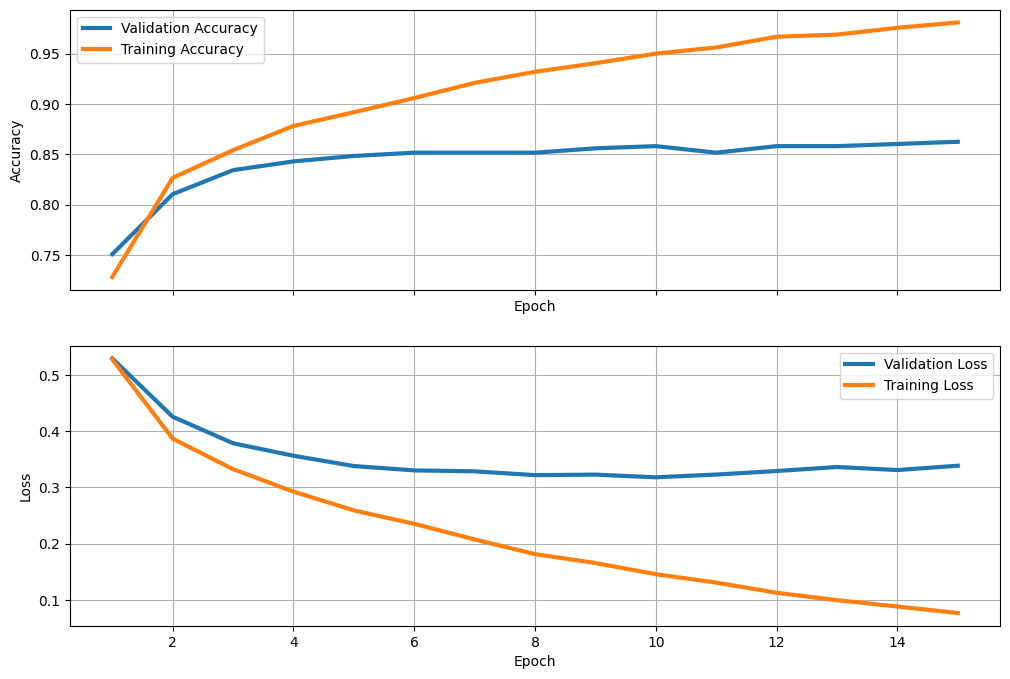

In [154]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\mobileNet\\binary\\graph.png')
plt.show()

73/73 [==============================] - 4s 29ms/step


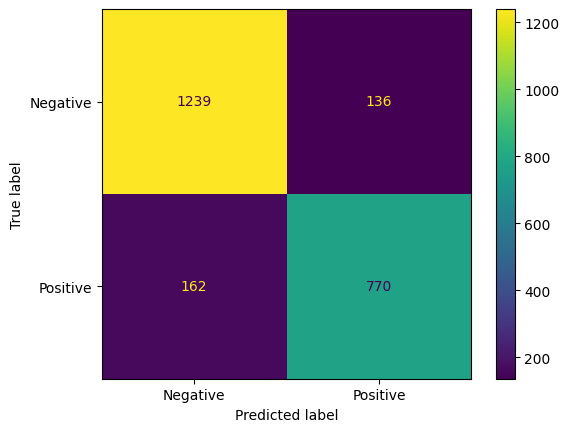

In [155]:
y_pred = np.where(pos_mobnet.predict(test_data_pos) > 0.5, 1, 0)

confusion_matrix = metrics.confusion_matrix(y_test_nn_ispos, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive']
)
cm_display.plot()
# plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\mobileNet\\binary\\confusion_matrix.png')
plt.show()

In [156]:
pos_mobnet.evaluate(test_data_pos)

73/73 [==============================] - 2s 33ms/step - loss: 0.3219 - accuracy: 0.8708


[0.3219260573387146, 0.8708279132843018]

In [157]:
print(metrics.classification_report(y_test_nn_ispos, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1375
           1       0.85      0.83      0.84       932

    accuracy                           0.87      2307
   macro avg       0.87      0.86      0.87      2307
weighted avg       0.87      0.87      0.87      2307



In [158]:
pos_mobnet.save('.\\model_data\\nn\\mobileNet\\binary\\model.keras')

#### All Classes

In [ ]:
all_mobnet = tf.keras.models.load_model(
    '.\\model_data\\nn\\mobileNet\\multiclass\\model.keras'
)
all_mobnet.summary()

In [195]:
input = Input(shape=(100, 100, 3))
preprocess = mobilenet_v2.preprocess_input(input)
mobnet = mobilenet_v2.MobileNetV2(include_top=False, input_tensor=preprocess)
global_pool = GlobalAveragePooling2D()(mobnet.output)
output = Dense(6, activation='softmax')(global_pool)

all_mobnet = tf.keras.Model(inputs=input, outputs=output)
all_mobnet.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_18 (TFOpLambda  (None, 100, 100, 3)  0          ['input_30[0][0]']               
 )                                                                                                
                                                                                                  
 tf.math.subtract_13 (TFOpLambd  (None, 100, 100, 3)  0          ['tf.math.truediv_18[0][0]']     
 a)                                                                                        

In [196]:
# number of layers that will be trained
trainable_layers = len(all_mobnet.layers) / 7

for i, l in enumerate(all_mobnet.layers):
    if len(all_mobnet.layers) - i <= trainable_layers:
        l.trainable = True
    else:
        l.trainable = False

all_mobnet.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_18 (TFOpLambda  (None, 100, 100, 3)  0          ['input_30[0][0]']               
 )                                                                                                
                                                                                                  
 tf.math.subtract_13 (TFOpLambd  (None, 100, 100, 3)  0          ['tf.math.truediv_18[0][0]']     
 a)                                                                                        

In [197]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)

all_mobnet.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [198]:
epochs = 32
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = all_mobnet.fit(
    train_data_all, epochs=epochs, validation_data=val_data_all, callbacks=[callback]
)

Epoch 1/32


260/260 [==============================] - 7s 20ms/step - loss: 1.1182 - accuracy: 0.6016 - val_loss: 1.7720 - val_accuracy: 0.4301
Epoch 2/32
260/260 [==============================] - 5s 17ms/step - loss: 0.7709 - accuracy: 0.7273 - val_loss: 1.3478 - val_accuracy: 0.5612
Epoch 3/32
260/260 [==============================] - 4s 17ms/step - loss: 0.6530 - accuracy: 0.7673 - val_loss: 1.0105 - val_accuracy: 0.6349
Epoch 4/32
260/260 [==============================] - 4s 17ms/step - loss: 0.5611 - accuracy: 0.8027 - val_loss: 0.9572 - val_accuracy: 0.6696
Epoch 5/32
260/260 [==============================] - 4s 16ms/step - loss: 0.4908 - accuracy: 0.8274 - val_loss: 0.8599 - val_accuracy: 0.7031
Epoch 6/32
260/260 [==============================] - 4s 16ms/step - loss: 0.4336 - accuracy: 0.8495 - val_loss: 0.8073 - val_accuracy: 0.7205
Epoch 7/32
260/260 [==============================] - 4s 17ms/step - loss: 0.3726 - accuracy: 0.8790 - val_loss: 0.8008 - val_accuracy: 0.7281
Epoch 8/32

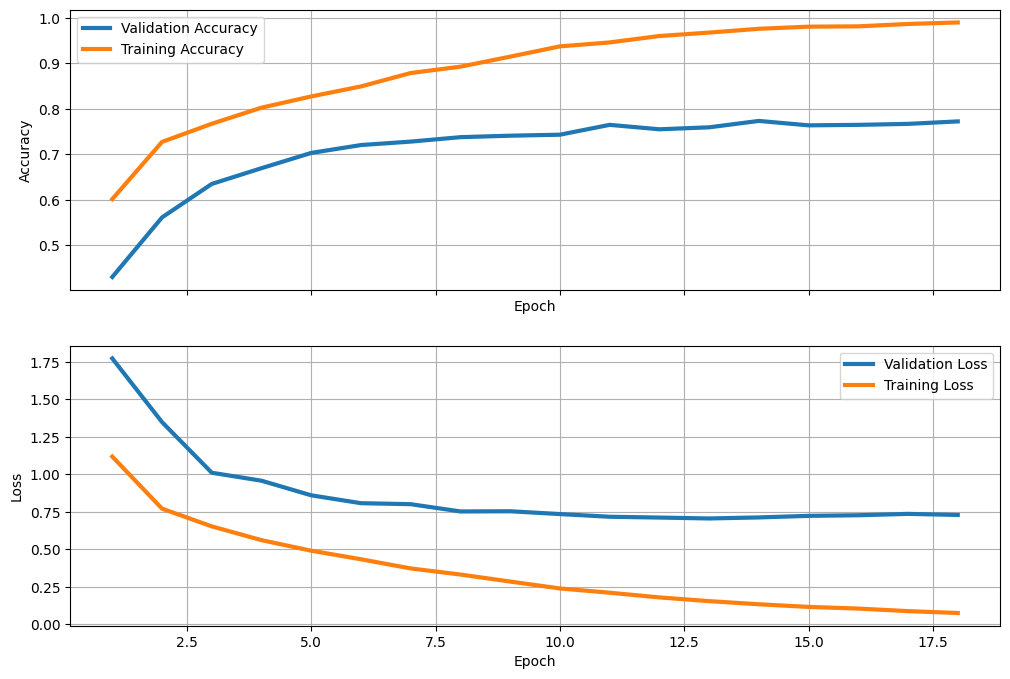

In [199]:
fig, axs = plot_results(history, show=False)
plt.savefig('.\\model_data\\nn\\mobileNet\\multiclass\\graph.png')
plt.show()

73/73 [==============================] - 1s 14ms/step


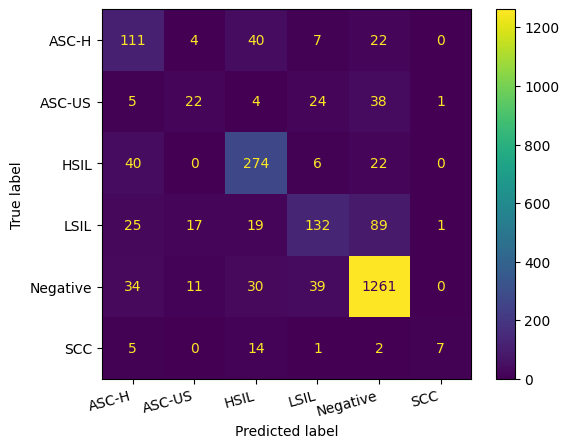

In [200]:
y_pred = np.argmax(all_mobnet.predict(test_data_all), axis=1)

confusion_matrix = metrics.confusion_matrix(y_test_all_classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=label_encoder.classes_
)
cm_display.plot()
plt.xticks(rotation=15, ha='right')

plt.savefig('.\\model_data\\nn\\mobileNet\\multiclass\\confusion_matrix.png')
plt.show()

In [201]:
all_mobnet.evaluate(test_data_all)

 1/73 [..............................] - ETA: 3s - loss: 0.9374 - accuracy: 0.6875

73/73 [==============================] - 1s 14ms/step - loss: 0.6677 - accuracy: 0.7833


[0.6676563024520874, 0.7832683324813843]

In [202]:
print(metrics.classification_report(y_test_all_classes, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.60      0.55       184
           1       0.41      0.23      0.30        94
           2       0.72      0.80      0.76       342
           3       0.63      0.47      0.54       283
           4       0.88      0.92      0.90      1375
           5       0.78      0.24      0.37        29

    accuracy                           0.78      2307
   macro avg       0.65      0.54      0.57      2307
weighted avg       0.77      0.78      0.77      2307



In [203]:
all_mobnet.save('.\\model_data\\nn\\mobileNet\\multiclass\\model.keras')